Example of how to do VE analasys with pyPAS.
Due to the memory the energy dependence is only up to 5 keV instead of 15


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import math
import matplotlib.pyplot as plt
from pyspectrum import germanium_fwhm,TimeChannelParser
from pyPAS import PASdb, PAScdb,PasCoincidenceFilter
from pathlib import Path
import os
from uncertainties import ufloat, std_dev, nominal_value
from uncertainties.unumpy import nominal_values, std_devs


 utils

In [4]:
def ufloat_converter(string):
    parts = string.split('+/-')
    if len(parts) == 2:
        return ufloat(float(parts[0]), float(parts[1]))
    else:
        return None

definitions

In [5]:
energy_calib_poly_det_1 = np.poly1d([0.0408976444, 0.0822321508])
energy_calib_poly_det_2 = np.poly1d([0.0418921521, 0.0653720462])

energy_resolution_det_1 = 1.05 
energy_resolution_det_2 = 1.08 

estimated_FWHM_det_1 = lambda energy: germanium_fwhm(energy, 0, energy_resolution_det_1/511**0.5, 0)
estimated_FWHM_det_2 = lambda energy: germanium_fwhm(energy, 0, energy_resolution_det_2/511**0.5, 0)

energy_domain_s = [510.1,511.9]
energy_domain_w_l = [506,509.3]
energy_domain_w_r = [512.7,516]
total_energy_domain = [506, 516]

# Cu 500

## files

In [7]:
data_dir_cu_detector_1 = Path('./libs/cu_sample_500/detector_0/')
data_dir_cu_detector_2 = Path('./libs/cu_sample_500/detector_1/')

files_in_dir_cu_detector_1 = os.listdir(data_dir_cu_detector_1)
files_in_dir_cu_detector_2 = os.listdir(data_dir_cu_detector_2)

# now we take the data for the two detector
db_spectra_files_cu_detector_1 = []
db_spectra_files_cu_detector_2 = []

energies_cu_detector_1 = []
energies_cu_detector_2 = []

for file in files_in_dir_cu_detector_1:
    db_spectra_files_cu_detector_1.append(data_dir_cu_detector_1 / file)
    energies_cu_detector_1.append(float(file[:file.find('e')])/1000)
    
for file in files_in_dir_cu_detector_2:
    db_spectra_files_cu_detector_2.append(data_dir_cu_detector_2 / file)
    energies_cu_detector_2.append(float(file[:file.find('e')])/1000)


### creating DB obejects

In [8]:
db_cu_detector_1 = []
db_cu_detector_2 = []

s_cu_detector_1 = []
s_cu_detector_2 = []
w_cu_detector_1 = []
w_cu_detector_2 = []

energies_cu = []

for energy in energies_cu_detector_1:
    
    file_1 = db_spectra_files_cu_detector_1[energies_cu_detector_1.index(energy)]
    file_2 = db_spectra_files_cu_detector_2[energies_cu_detector_2.index(energy)]

    data_cu_detector_1 = TimeChannelParser.to_dataframe(file_1)
    spectrum_cu_detector_1 = Spectrum.from_dataframe(TimeChannelParser.counts_in_time_into_spectrum(data_cu_detector_1), energy_calib_poly_det_1, estimated_FWHM_det_1)
    db = PASdb.from_spectrum(spectrum_cu_detector_1)
    new_coords = {'channel': db.peak.channel - (nominal_value(db.first_moment_method_center())- 511)}
    db.peak = db.peak.assign_coords(new_coords)
    db_cu_detector_1.append(db)
    s_cu_detector_1.append(db_cu_detector_1[-1].s_parameter_calculation(total_energy_domain, energy_domain_s).item())
    w_cu_detector_1.append(db_cu_detector_1[-1].w_parameter_calculation(total_energy_domain, energy_domain_w_l, energy_domain_w_r).item())
        
    data_cu_detector_2 = TimeChannelParser.to_dataframe(file_2)
    spectrum_cu_detector_2 = Spectrum.from_dataframe(TimeChannelParser.counts_in_time_into_spectrum(data_cu_detector_2), energy_calib_poly_det_2, estimated_FWHM_det_2)
    db = PASdb.from_spectrum(spectrum_cu_detector_2)
    new_coords = {'channel': db.peak.channel - (nominal_value(db.first_moment_method_center())- 511)}
    db.peak = db.peak.assign_coords(new_coords)
    db_cu_detector_2.append(db)
    s_cu_detector_2.append(db_cu_detector_2[-1].s_parameter_calculation(total_energy_domain, energy_domain_s).item())
    w_cu_detector_2.append(db_cu_detector_2[-1].w_parameter_calculation(total_energy_domain, energy_domain_w_l, energy_domain_w_r).item())
    
    energies_cu.append(energy)
    
s_cu_detector_1 = np.array(s_cu_detector_1)
s_cu_detector_2 = np.array(s_cu_detector_2)
w_cu_detector_1 = np.array(w_cu_detector_1)
w_cu_detector_2 = np.array(w_cu_detector_2)

# Plots

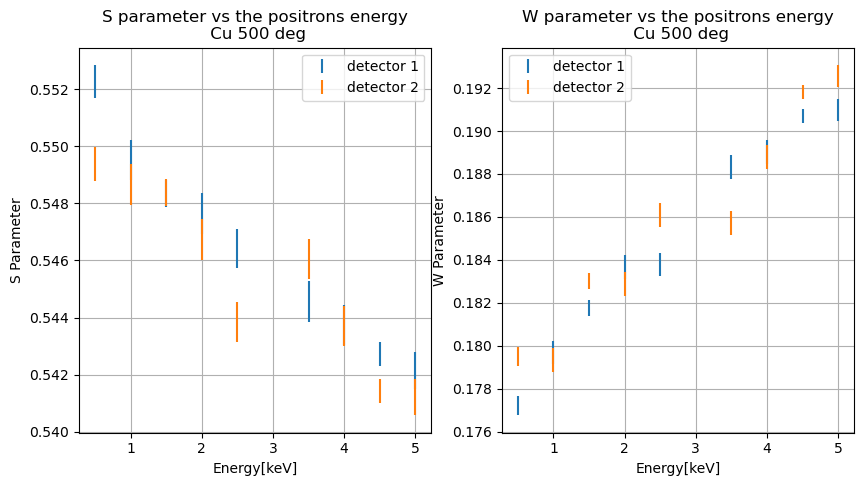

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 3 columns, 1st subplot

plt.errorbar(x=energies_cu, y=nominal_values(s_cu_detector_1), yerr=std_devs(s_cu_detector_1), ls='')
plt.errorbar(x=energies_cu, y=nominal_values(s_cu_detector_2), yerr=std_devs(s_cu_detector_2), ls='')

plt.title('S parameter vs the positrons energy\n Cu 500 deg')
plt.grid(True)
plt.xlabel('Energy[keV]')
plt.ylabel('S Parameter')
plt.legend(['detector 1', 'detector 2'])

plt.subplot(1, 2, 2)  # 1 row, 3 columns, 1st subplot

plt.errorbar(x=energies_cu, y=nominal_values(w_cu_detector_1), yerr=std_devs(w_cu_detector_1), ls='')
plt.errorbar(x=energies_cu, y=nominal_values(w_cu_detector_2), yerr=std_devs(w_cu_detector_2), ls='')

plt.title('W parameter vs the positrons energy\n Cu 500 deg')
plt.grid(True)
plt.xlabel('Energy[keV]')
plt.ylabel('W Parameter')
plt.legend(['detector 1', 'detector 2'])


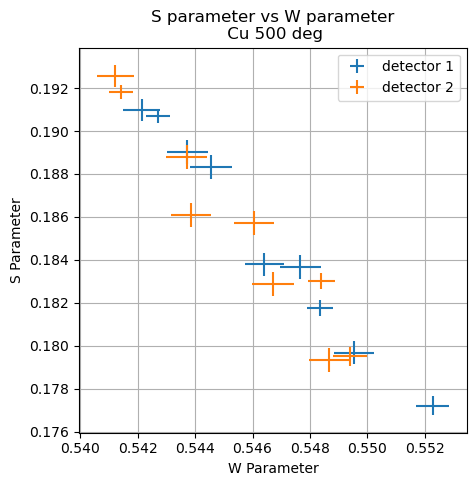

In [10]:
plt.figure(figsize=(5, 5))

plt.errorbar(x=nominal_values(s_cu_detector_1), y=nominal_values(w_cu_detector_1), yerr=std_devs(w_cu_detector_1), xerr=std_devs(s_cu_detector_1), ls='')
plt.errorbar(x=nominal_values(s_cu_detector_2), y=nominal_values(w_cu_detector_2), yerr=std_devs(w_cu_detector_2), xerr=std_devs(s_cu_detector_2), ls='')

plt.title('S parameter vs W parameter\n Cu 500 deg')
plt.grid(True)
plt.xlabel('W Parameter')
plt.ylabel('S Parameter')
plt.legend(['detector 1', 'detector 2'])